In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#### Dependencies ####
#### Import Comet for experiment tracking and visual tools
!pip install comet_ml
from comet_ml import Experiment
####
import IPython.display as ipd
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
from scipy.io import wavfile as wav
from sklearn import metrics 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import Adam
from keras.utils import to_categorical


In [ ]:
experiment = Experiment(api_key="MjRE0OU0vZuDW6s9JxXSa2u7j",
                        project_name="neuronske", workspace="coperope")

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/coperope/neuronske/b6f1716ad4d34bf1bf3bdebacdba3a93



In [ ]:
fn = '/content/drive/MyDrive/neuronske/data/Synthetic_dataset/audio/train/synthetic/10.wav'
librosa_audio, librosa_sample_rate = librosa.load(fn)
scipy_sample_rate, scipy_audio = wav.read(fn)

print("Original sample rate: {}".format(scipy_sample_rate))
print("Librosa sample rate: {}".format(librosa_sample_rate))

Original sample rate: 44100
Librosa sample rate: 22050


In [ ]:
print('Original audio file min~max range: {} to {}'.format(np.min(scipy_audio), np.max(scipy_audio)))
print('Librosa audio file min~max range: {0:.2f} to {0:.2f}'.format(np.min(librosa_audio), np.max(librosa_audio)))

Original audio file min~max range: -20458 to 30337
Librosa audio file min~max range: -0.61 to -0.61


NameError: ignored

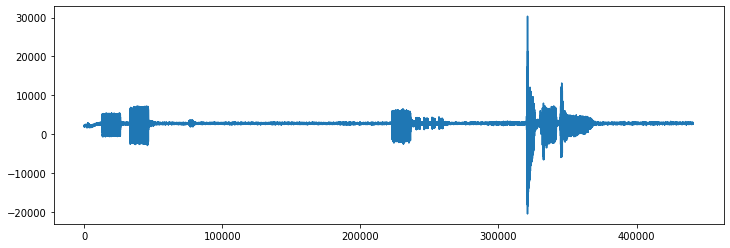

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(scipy_audio)
plt.savefig('original_audio.png')
experiment.log_image('original_audio.png')

{'api': 'https://www.comet.ml/api/rest/v1/image/get-image?imageId=5e9ce7b4d30748ea8428ce2c6c2c23fe&experimentKey=8009c997e8d84653a3c4b1dd57c42f44',
 'imageId': '5e9ce7b4d30748ea8428ce2c6c2c23fe',
 'web': 'https://www.comet.ml/api/image/download?imageId=5e9ce7b4d30748ea8428ce2c6c2c23fe&experimentKey=8009c997e8d84653a3c4b1dd57c42f44'}

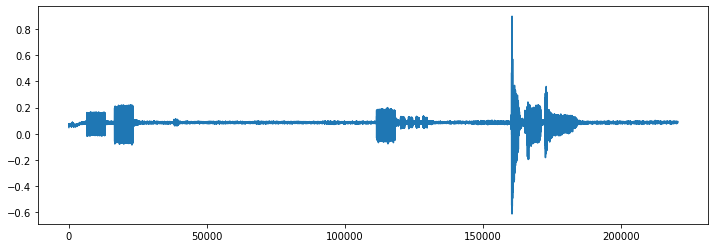

In [ ]:
# Librosa: mono track
plt.figure(figsize=(12,4))
plt.plot(librosa_audio)
plt.savefig('librosa_audio.png')
experiment.log_image('librosa_audio.png')

In [ ]:
mfccs = librosa.feature.mfcc(y=librosa_audio, sr=librosa_sample_rate, n_mfcc = 40)
print(mfccs.shape)


(40, 431)


{'api': 'https://www.comet.ml/api/rest/v1/image/get-image?imageId=0574a589502f48609b4645c37019e64a&experimentKey=8009c997e8d84653a3c4b1dd57c42f44',
 'imageId': '0574a589502f48609b4645c37019e64a',
 'web': 'https://www.comet.ml/api/image/download?imageId=0574a589502f48609b4645c37019e64a&experimentKey=8009c997e8d84653a3c4b1dd57c42f44'}

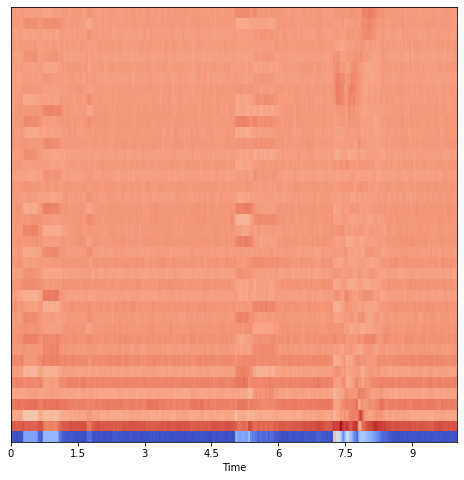

In [ ]:
import librosa.display

plt.figure(figsize=(8,8))
librosa.display.specshow(mfccs, sr=librosa_sample_rate, x_axis='time')
plt.savefig('MFCCs.png')
experiment.log_image('MFCCs.png')

In [ ]:
events = pd.read_csv("/content/drive/MyDrive/neuronske/data/Synthetic_dataset/synthetic_dataset.csv", delimiter="\t") 
events.head()

distinct_events = events['event_label'].unique()
print(distinct_events)

from sklearn.preprocessing import OneHotEncoder

onehot_encoder = OneHotEncoder()
onehot_encoder.fit(distinct_events.reshape(len(distinct_events), 1))


['Alarm_bell_ringing' 'Speech' 'Dog' 'Cat' 'Dishes' 'Running_water'
 'Blender' 'Frying' 'Vacuum_cleaner' 'Electric_shaver_toothbrush']


OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='error', sparse=True)

In [ ]:
e = events.iloc[0]['event_label']
e = np.asarray([e])
e = np.append(e, 'Speech')
print(e)
print(onehot_encoder.transform(e.reshape(-1, 1)).toarray())


['Alarm_bell_ringing' 'Speech']
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]


In [ ]:
import os

dir_path = '/content/drive/MyDrive/neuronske/data/Synthetic_dataset/audio/train/synthetic/'

filename_mfcc_labels = []
counter = 0

for filename in os.listdir(dir_path):
  # if counter == 2:
          # break
  counter = counter + 1
  if counter % 200 == 0:
    print("STIGAO DO " + str(counter)) 

  if filename.endswith(".wav"):   

    path = os.path.join(dir_path, filename)
    librosa_audio, librosa_sample_rate = librosa.load(path)
    mfccs = librosa.feature.mfcc(y=librosa_audio, sr=librosa_sample_rate, n_mfcc = 13)

    # mfccs_processed = np.mean(mfccs.T,axis=0) # FOR SIMPLE NN

    mfccs_processed = mfccs

    filename_events = events[events['filename'] == filename]['event_label'].unique()

    one_hot_events = onehot_encoder.transform(filename_events.reshape(len(filename_events), 1)).toarray()
    onehot_events_to_process = np.array([])
    for e in one_hot_events:
      onehot_events_to_process = e.astype(int) | onehot_events_to_process.astype(int) if len(onehot_events_to_process) > 0 else e

    filename_mfcc_labels.append([filename, mfccs_processed, onehot_events_to_process])
    continue
  else:
    continue

# Convert into a Panda dataframe 
featuresdf = pd.DataFrame(filename_mfcc_labels, columns=['filename','mfccs','labels'])
featuresdf.head()


featuresdf.to_pickle('/content/drive/MyDrive/neuronske/data/dataset_full_mfcc_n13.pkl')
#pd.read_pickle('/content/drive/MyDrive/neuronske/data/dataset.p')

STIGAO DO 200
STIGAO DO 400
STIGAO DO 600
STIGAO DO 800
STIGAO DO 1000
STIGAO DO 1200
STIGAO DO 1400
STIGAO DO 1600
STIGAO DO 1800
STIGAO DO 2000


In [ ]:
featuresdf = pd.read_pickle('/content/drive/MyDrive/neuronske/data/dataset_mean_mfcc.pkl')
X = np.array(featuresdf.mfccs.tolist())
y = np.array(featuresdf.labels.tolist())

# split the dataset 
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)


In [ ]:
print(y.shape[1])
print(X.shape[1])


10
40


In [ ]:
print(X[0])

[-4.3330576e+02  5.5486675e+01 -3.4598206e+01  3.8344273e+01
 -1.6721098e+01  2.1408051e+01 -1.0375176e+01  1.7963964e+01
 -4.9358006e+00  9.6914721e+00  2.0415633e+00  2.7927234e+00
  6.1048779e+00 -3.6350358e-01  7.0056300e+00 -2.5845499e+00
  8.1334114e+00 -6.6124648e-01  4.1163883e+00  3.6156456e+00
  3.0149312e+00  6.9677768e+00  4.2211618e-03  1.0471678e+01
 -3.2449353e-01  8.0006704e+00 -5.5726338e-02  6.8497667e+00
 -5.0468260e-01  4.5424266e+00  2.2086728e+00  5.3258953e+00
  5.1766558e+00  2.2836053e+00  6.6100693e+00  2.8914475e+00
  4.5849771e+00  1.5612388e+00  4.1966310e+00  3.1682339e+00]


In [ ]:
from tensorflow.keras import metrics

num_labels = y.shape[1]
filter_size = 2

def build_model(input_dimension):
    model = Sequential()
    model.add(Dense(1024, input_shape=(input_dimension,)))
    model.add(Activation('selu'))
    model.add(Dropout(0.2))
    model.add(Dense(1024))
    model.add(Activation('selu'))
    model.add(Dropout(0.2))
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_labels))
    model.add(Activation('sigmoid'))
    # Compile the model
    model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')
    return model

In [ ]:
nn_model = build_model(X.shape[1])
nn_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 1024)              41984     
_________________________________________________________________
activation_19 (Activation)   (None, 1024)              0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
activation_20 (Activation)   (None, 1024)              0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 256)              

In [ ]:
from keras.callbacks import ModelCheckpoint 
from datetime import datetime 

num_epochs = 500
num_batch_size = 64
nn_model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), verbose=1)

Epoch 1/500
26/26 [==============================] - 1s 10ms/step - loss: 4.4522 - accuracy: 0.0905 - val_loss: 0.5420 - val_accuracy: 0.0587
Epoch 2/500
26/26 [==============================] - 0s 5ms/step - loss: 0.5641 - accuracy: 0.1143 - val_loss: 0.4812 - val_accuracy: 0.0587
Epoch 3/500
26/26 [==============================] - 0s 5ms/step - loss: 0.5128 - accuracy: 0.0894 - val_loss: 0.4172 - val_accuracy: 0.0587
Epoch 4/500
26/26 [==============================] - 0s 5ms/step - loss: 0.4715 - accuracy: 0.0809 - val_loss: 0.4157 - val_accuracy: 0.0587
Epoch 5/500
26/26 [==============================] - 0s 5ms/step - loss: 0.4658 - accuracy: 0.0537 - val_loss: 0.4255 - val_accuracy: 0.0587
Epoch 6/500
26/26 [==============================] - 0s 5ms/step - loss: 0.4525 - accuracy: 0.0544 - val_loss: 0.4020 - val_accuracy: 0.0611
Epoch 7/500
26/26 [==============================] - 0s 5ms/step - loss: 0.4459 - accuracy: 0.0578 - val_loss: 0.3999 - val_accuracy: 0.0587
Epoch 8/500


In [ ]:
# Evaluating the model on the training and testing set
score = nn_model.evaluate(X_train, y_train, verbose=0)
print("Training Accuracy: {0:.2%}".format(score[1]))
score = nn_model.evaluate(X_test, y_test, verbose=0)
print("Testing Accuracy: {0:.2%}".format(score[1]))

Training Accuracy: 57.46%
Testing Accuracy: 23.96%


In [ ]:
temp = np.asarray(X_test[2])
print("SHAPE", temp.shape)


predict = nn_model.predict(temp.reshape(1, -1))
t = predict > 0.5
print("predict", predict)
print("PREDICTED", t)
print("Y_TEST", y_test[2])

SHAPE (40,)
predict [[4.1792123e-06 9.9561912e-01 7.6135507e-07 9.7162318e-01 6.8753059e-07
  6.4783336e-08 9.7692082e-06 1.1404062e-06 2.9452062e-01 1.9888748e-05]]
PREDICTED [[False  True False  True False False False False False False]]
Y_TEST [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


In [ ]:
from sklearn.metrics import classification_report
y_pred = nn_model.predict(X_test, batch_size=64, verbose=1)
y_pred = (y_pred > 0.5)

print(classification_report(y_test, y_pred, zero_division=0))


7/7 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.56      0.28      0.37        80
           1       0.41      0.38      0.40        84
           2       0.47      0.33      0.39        52
           3       0.43      0.32      0.37       102
           4       0.35      0.39      0.37        46
           5       0.49      0.52      0.51        46
           6       0.63      0.57      0.60        21
           7       0.33      0.13      0.19        30
           8       0.72      0.75      0.73       260
           9       0.63      0.29      0.40        41

   micro avg       0.57      0.48      0.52       762
   macro avg       0.50      0.40      0.43       762
weighted avg       0.55      0.48      0.51       762
 samples avg       0.54      0.47      0.47       762



In [ ]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/coperope/neuronske/b6f1716ad4d34bf1bf3bdebacdba3a93
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     accuracy [2500]                                 : (0.05317848548293114, 0.604523241519928)
COMET INFO:     batch_accuracy [7700]                           : (0.0, 0.71875)
COMET INFO:     batch_loss [9500]                               : (0.009548461064696312, 6899172.5)
COMET INFO:     batch_top_k_categorical_accuracy [1800]         : (0.59375, 1.0)
COMET INFO:     epoch_duration [2800]                           : (0.05353623099995275, 3.6144262609999487)
COMET INFO:     loss [2800]                                     : (0.024495640769600868, 6156698.5)
COMET INFO:     top_k_categorical_accuracy [300]                : (0.9376528263092041,

In [ ]:
# WHEN USING AGREGATED MFCCS FOR LSTM

X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

print(X_train.shape)

In [ ]:
featuresdf = pd.read_pickle('/content/drive/MyDrive/neuronske/data/dataset_full_mfcc_n13.pkl')
X = np.array(featuresdf.mfccs.tolist())
y = np.array(featuresdf.labels.tolist())

# split the dataset 
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

In [ ]:
print(y.shape[1])
print(X.shape[1])

10
13


In [ ]:
print(X.shape)

(2045, 13, 431)


In [ ]:
print(X[5].shape)

(40, 431)


In [16]:
import tensorflow.keras as keras
import matplotlib.pyplot as plt

def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs
        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

In [ ]:
def build_model_lstm(input_shape):
    """Generates RNN-LSTM model
    :param input_shape (tuple): Shape of input set
    :return model: RNN-LSTM model
    """

    # build network topology
    model = keras.Sequential()

    # 2 LSTM layers
    model.add(keras.layers.GRU(512, input_shape=input_shape, return_sequences=True))
    model.add(keras.layers.GRU(512))

    # dense layer
    model.add(keras.layers.Dense(512, activation='relu'))
    model.add(keras.layers.Dropout(0.2))

    # output layer
    model.add(keras.layers.Dense(10, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

    return model

In [ ]:
input_shape = (X_train.shape[1], X_train.shape[2]) 
model = build_model_lstm(input_shape)

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_31 (GRU)                 (None, 13, 512)           1451520   
_________________________________________________________________
gru_32 (GRU)                 (None, 512)               1575936   
_________________________________________________________________
dense_74 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_38 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_75 (Dense)             (None, 10)                5130      
Total params: 3,295,242
Trainable params: 3,295,242
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
26/26 [==============================] - 4s 40ms/step - loss: 0.4880 - accuracy: 0.0925 - val_los

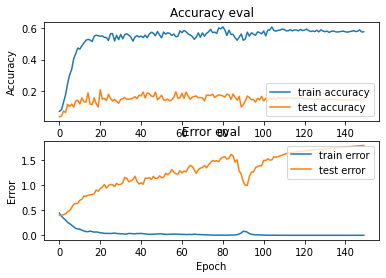

In [ ]:

model.summary()

# train model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=64, epochs=150)

# plot accuracy/error for training and validation
plot_history(history)

In [ ]:
from sklearn.metrics import classification_report
y_pred = model.predict(X_test, batch_size=64, verbose=1)
y_pred = (y_pred > 0.5)

print(classification_report(y_test, y_pred, zero_division=0))


7/7 [==============================] - 1s 6ms/step
              precision    recall  f1-score   support

           0       0.35      0.31      0.33        78
           1       0.32      0.30      0.31        81
           2       0.16      0.08      0.11        62
           3       0.27      0.15      0.19        95
           4       0.24      0.15      0.19        65
           5       0.51      0.42      0.46        43
           6       0.25      0.17      0.20        18
           7       0.21      0.10      0.14        29
           8       0.66      0.75      0.70       235
           9       0.34      0.33      0.34        33

   micro avg       0.46      0.39      0.42       739
   macro avg       0.33      0.28      0.30       739
weighted avg       0.41      0.39      0.39       739
 samples avg       0.42      0.36      0.37       739



In [23]:
import math

def chunks(lst, n):
  """Yield successive n-sized chunks from lst."""
  return ([lst[i:i + n] for i in range(0, len(lst), n)])


def split_sequences_into_seconds_yclass(X, y, seconds = 1):
  sequence_len = X.shape[1]
  ticks_per_chosen_second = math.ceil(sequence_len / (10 / seconds))
  num_of_parts_of_sequence = math.ceil(sequence_len / ticks_per_chosen_second)

  X_new = []
  y_new = []
  for i, sequence in enumerate(X):
    X_splits = chunks(sequence, ticks_per_chosen_second)
    x_false_instances = np.array([]).reshape(0,X_splits[0].shape[1])
    for j, X_split in enumerate(X_splits):
      X_temp = X_split
      y_temp = y[i]

      diff = ticks_per_chosen_second - len(X_temp)
      if diff != 0:
        X_temp = np.append(X_temp, X_temp[0: diff], axis=0)
        
      X_new.append(X_temp)
      y_new.append(y_temp)


  return np.asarray(X_new), np.asarray(y_new)

In [95]:
!pip install scikit-multilearn

     |████████████████████████████████| 92kB 5.3MB/s 


In [104]:
featuresdf = pd.read_pickle('/content/drive/MyDrive/neuronske/data/dataset_full_mfcc.pkl')
X = np.array(featuresdf.mfccs.tolist())
y = np.array(featuresdf.labels.tolist())
print(X.shape)

(2045, 40, 431)


In [107]:
arr = X
orig_shape = arr.shape
print(orig_shape)
X = np.reshape(arr, (arr.shape[0], arr.shape[1] * arr.shape[2]))
print(X.shape)
# arr = np.reshape(arr, orig_shape)
# print(arr.shape)

(2045, 40, 431)
(2045, 17240)


In [108]:
from skmultilearn.problem_transform import LabelPowerset
from imblearn.over_sampling import RandomOverSampler

# Import a dataset with X and multi-label y
lp = LabelPowerset()
ros = RandomOverSampler() # sampling_strategy='minority'

# Applies the above stated multi-label (ML) to multi-class (MC) transformation.
yt = lp.transform(y)

X_resampled, y_resampled = ros.fit_resample(X, yt)

# Inverts the ML-MC transformation to recreate the ML set
y_resampled = lp.inverse_transform(y_resampled)

  
print('After OverSampling, the shape of train_X: {}'.format(X_resampled.shape)) 
print('After OverSampling, the shape of train_y: {} \n'.format(y_resampled.shape)) 
X = X_resampled
y = y_resampled

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



After OverSampling, the shape of train_X: (11928, 17240)
After OverSampling, the shape of train_y: (11928, 10) 



In [126]:
X = np.reshape(X, (X_resampled.shape[0], 40, 431))
print(X.shape)
X = X[..., np.newaxis]
print(X.shape)


(11928, 40, 431)
(11928, 40, 431, 1)


In [175]:
featuresdf = pd.read_pickle('/content/drive/MyDrive/neuronske/data/dataset_full_mfcc.pkl')
X = np.array(featuresdf.mfccs.tolist())
y = np.array(featuresdf.labels.tolist())

X = X[..., np.newaxis]


In [176]:
print(X.shape)
B = np.einsum('ijkl->ikjl', X)
print(B.shape)
X = B

(2045, 40, 431, 1)
(2045, 431, 40, 1)


In [174]:
X, y = split_sequences_into_seconds_yclass(X, y, 5)
print(X.shape)
print(y.shape)

(4090, 216, 40, 1)
(4090, 10)


In [177]:

# split the dataset 
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

In [178]:
import tensorflow.keras as keras
from keras.metrics import BinaryAccuracy, Precision, Recall, AUC

METRICS = [
    Precision(name='precision'),
    Recall(name='recall'),
    AUC(name='auc'),
    AUC(name='prc', curve='PR'), # precision-recall curve
]

def build_model_cnn(input_shape):
    """Generates CNN model
    :param input_shape (tuple): Shape of input set
    :return model: CNN model
    """

    # build network topology
    model = keras.Sequential()

    # 1st conv layer
    model.add(keras.layers.Conv2D(128, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 2nd conv layer
    model.add(keras.layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 3rd conv layer
    model.add(keras.layers.Conv2D(64, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 3rd conv layer
    model.add(keras.layers.Conv2D(64, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 3rd conv layer
    model.add(keras.layers.Conv2D(64, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())
    

    # flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(256, activation='relu'))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dropout(0.2))
    # output layer
    model.add(keras.layers.Dense(10, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', metrics=METRICS, optimizer='adam')

    return model

In [179]:
input_shape = (X_train.shape[1], X_train.shape[2], 1)
model = build_model_cnn(input_shape)
model.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_118 (Conv2D)          (None, 429, 38, 128)      1280      
_________________________________________________________________
max_pooling2d_106 (MaxPoolin (None, 215, 19, 128)      0         
_________________________________________________________________
batch_normalization_113 (Bat (None, 215, 19, 128)      512       
_________________________________________________________________
conv2d_119 (Conv2D)          (None, 213, 17, 128)      147584    
_________________________________________________________________
max_pooling2d_107 (MaxPoolin (None, 107, 9, 128)       0         
_________________________________________________________________
batch_normalization_114 (Bat (None, 107, 9, 128)       512       
_________________________________________________________________
conv2d_120 (Conv2D)          (None, 106, 8, 64)      

In [180]:
# train model
checkpoint_filepath = '/content/drive/MyDrive/neuronske/models/checkpoint/cnn_multiclass'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
  filepath=checkpoint_filepath,
  save_weights_only=True,
  monitor='val_prc',
  mode='max',
  save_best_only=True)


history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=128, epochs=50, callbacks=[model_checkpoint_callback])

# plot accuracy/error for training and validation

Epoch 1/50
13/13 [==============================] - 6s 290ms/step - loss: 0.5259 - precision: 0.2942 - recall: 0.4643 - auc: 0.6257 - prc: 0.2983 - val_loss: 1.2547 - val_precision: 0.3655 - val_recall: 0.3855 - val_auc: 0.6653 - val_prc: 0.3433
Epoch 2/50
13/13 [==============================] - 3s 229ms/step - loss: 0.3974 - precision: 0.4089 - recall: 0.3710 - auc: 0.6945 - prc: 0.3678 - val_loss: 1.9009 - val_precision: 0.4116 - val_recall: 0.3870 - val_auc: 0.7051 - val_prc: 0.3603
Epoch 3/50
13/13 [==============================] - 3s 230ms/step - loss: 0.3438 - precision: 0.4370 - recall: 0.4000 - auc: 0.7242 - prc: 0.3766 - val_loss: 1.5702 - val_precision: 0.4450 - val_recall: 0.4152 - val_auc: 0.7316 - val_prc: 0.3812
Epoch 4/50
13/13 [==============================] - 3s 230ms/step - loss: 0.3029 - precision: 0.4655 - recall: 0.4282 - auc: 0.7467 - prc: 0.3980 - val_loss: 1.0944 - val_precision: 0.4721 - val_recall: 0.4407 - val_auc: 0.7536 - val_prc: 0.4076
Epoch 5/50
13/13

In [184]:
from sklearn.metrics import classification_report
# plot_history(history)
model.load_weights(checkpoint_filepath)

y_pred = model.predict(X_test, batch_size=64, verbose=1)
y_pred = (y_pred > 0.5)

print(classification_report(y_test, y_pred, zero_division=0))


7/7 [==============================] - 0s 41ms/step
              precision    recall  f1-score   support

           0       0.85      0.67      0.75        78
           1       0.80      0.48      0.60        81
           2       0.64      0.81      0.71        62
           3       0.57      0.32      0.41        95
           4       0.47      0.58      0.52        65
           5       0.88      0.81      0.84        43
           6       0.89      0.44      0.59        18
           7       0.75      0.52      0.61        29
           8       0.72      0.90      0.80       235
           9       0.71      0.45      0.56        33

   micro avg       0.70      0.67      0.68       739
   macro avg       0.73      0.60      0.64       739
weighted avg       0.71      0.67      0.67       739
 samples avg       0.70      0.68      0.66       739



.

.

. **SEQUENCE TO SEQUENCE PREPARATION**

.

.



In [ ]:
data = pd.read_pickle('/content/drive/MyDrive/neuronske/data/dataset_full_mfcc_n13.pkl')

data.head()


,filename,mfccs,labels
0,2282.wav,"[[-659.70654, -618.7009, -581.4676, -577.1263,...","[0, 0, 0, 0, 1, 0, 0, 0, 1, 0]"
1,2719.wav,"[[-584.7399, -515.89514, -473.47324, -464.3819...","[0, 0, 0, 0, 0, 1, 0, 0, 1, 0]"
2,1238.wav,"[[-401.96198, -400.9539, -411.34525, -405.876,...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,1204.wav,"[[-624.4009, -587.06744, -569.16077, -566.4556...","[0, 1, 0, 1, 0, 0, 0, 0, 1, 0]"
4,3407.wav,"[[-529.351, -534.64343, -551.51184, -555.8778,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."


In [ ]:
single_row = data.loc[0]
print(single_row)



filename                                             2282.wav
mfccs       [[-659.70654, -618.7009, -581.4676, -577.1263,...
labels                         [0, 0, 0, 0, 1, 0, 0, 0, 1, 0]
Name: 0, dtype: object


In [ ]:
events = pd.read_csv("/content/drive/MyDrive/neuronske/data/Synthetic_dataset/synthetic_dataset.csv", delimiter="\t") 
events.head()

,filename,onset,offset,event_label
0,10.wav,0.287159,1.057712,Alarm_bell_ringing
1,10.wav,1.717124,1.967124,Alarm_bell_ringing
2,10.wav,5.049573,6.013632,Alarm_bell_ringing
3,10.wav,7.240901,8.492352,Speech
4,1000.wav,4.352958,4.664092,Alarm_bell_ringing


In [ ]:
single_row_events = events[((events['filename'] == single_row.filename) & (events['event_label'] == 'Speech'))]
display(single_row_events.head())


,filename,onset,offset,event_label
2654,2282.wav,0.381144,1.21289,Speech
2655,2282.wav,3.221222,4.37680,Speech


In [ ]:
speech_sequence = np.zeros(431)
import math

const = 10 / 431

for index, event in single_row_events.iterrows():
  starting = math.ceil(event.onset / const)
  ending = math.floor(event.offset / const)
  speech_sequence[starting:ending] = 1


print(speech_sequence)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [ ]:
import math

const = 10 / 431

def create_sequence(r):
  starting = math.ceil(r.onset / const)
  ending = math.floor(r.offset / const)
  temp = np.zeros(431)
  r['sequence'][starting:ending] = [1 for i in range(ending - starting)]
  return r

def combine_squence_per_filename_and_event(r):
  return list(map(int, list(map(any, zip(*r)))))
new_events = events.copy()
new_events['sequence'] = np.zeros((6032, 431)).tolist()

new_events.apply(create_sequence, axis=1)
new_events.head()

result = new_events.groupby(['filename', 'event_label'])['sequence'].agg([combine_squence_per_filename_and_event])
result.head()
print(result.reset_index().loc[0].combine_squence_per_filename_and_event)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 